In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
df0 = pd.read_csv('listings.csv')

In [146]:
df = df0.copy()

# CLEANING DATA

In [147]:
# df.info()

# FIELDS WITH MISSING VALUES
df.isnull().sum().sort_values(ascending = False)[:27]

neighbourhood_group_cleansed    7625
bathrooms                       7625
calendar_updated                7625
host_about                      2473
neighborhood_overview           2378
neighbourhood                   2378
review_scores_communication     1500
review_scores_value             1499
review_scores_location          1499
review_scores_checkin           1499
review_scores_cleanliness       1499
review_scores_accuracy          1499
reviews_per_month               1484
first_review                    1484
last_review                     1484
review_scores_rating            1484
host_location                   1303
license                         1122
host_response_time               977
host_response_rate               977
host_acceptance_rate             759
bedrooms                         615
host_neighbourhood               328
beds                              65
bathrooms_text                    14
description                       11
host_is_superhost                  1
d

# LOOKING INTO BATHROOMS 

In [148]:
# bathrooms look null due to text input in bathrooms_text
#df['bathrooms_text'].value_counts()

# EXTRACTING bathroom_text to create features: numeric # of bathrooms + shared or private
# FLAGGING SHARED OR PRIVATE
df['bathrooms_shared'] = np.where(df['bathrooms_text'].str.contains('share', na= False, case = False),1,0)

# Identifying half-baths... index and turning them into .5
half_bath_index = df[df['bathrooms_text'].str.contains('half', na= False, case = False)]['bathrooms_text'].index
df.iloc[half_bath_index,df.columns.tolist().index('bathrooms_text')] = .5

# Standardizing bathroom text entry: identifying bathrooms without a number in front
split_bath = df['bathrooms_text'].str.split().str[0]
# Identifying the numbers of bathrooms per listing and turning them into just the number
numeric_bathroom_index = split_bath[pd.to_numeric(split_bath, errors = 'coerce').notnull()].index
split_bath = df.iloc[numeric_bathroom_index]['bathrooms_text'].str.split().str[0]
df.iloc[numeric_bathroom_index,df.columns.tolist().index('bathrooms_text')]=split_bath

# number of Bathrooms final update = numeric
df['bathrooms_text'] = pd.to_numeric(df['bathrooms_text'])

# renaming column bathrooms_text to bathrooms_count
df.rename(columns = {'bathrooms_text':'bathrooms_count'}, inplace = True)
# dropping bathrooms
df.drop('bathrooms', axis = 1, inplace = True)


In [149]:
# dropping listings without bathrooms
pre_drop = len(df)
df = df[~df['bathrooms_count'].isnull()].reset_index(drop = True)
print(str(pre_drop - len(df))+' out of ' + str(pre_drop) +' listings were dropped.')

14 out of 7625 listings were dropped.


# CLEANING OUTLIER PRICES - Part 1

In [150]:
# Exploring outliers # modified IQR (2.5*)
def outlier(field, multiplier):
    IQR = df[field].quantile(.75)-df[field].quantile(.25)
    top = df[field].quantile(.75) + IQR * multiplier
    btm = df[field].quantile(.25) - IQR * multiplier
    listy=[top,btm]
    return listy
df['price']= df['price'].str[1:].replace(',','',regex = True).astype(float)

Text(0, 0.5, '$')

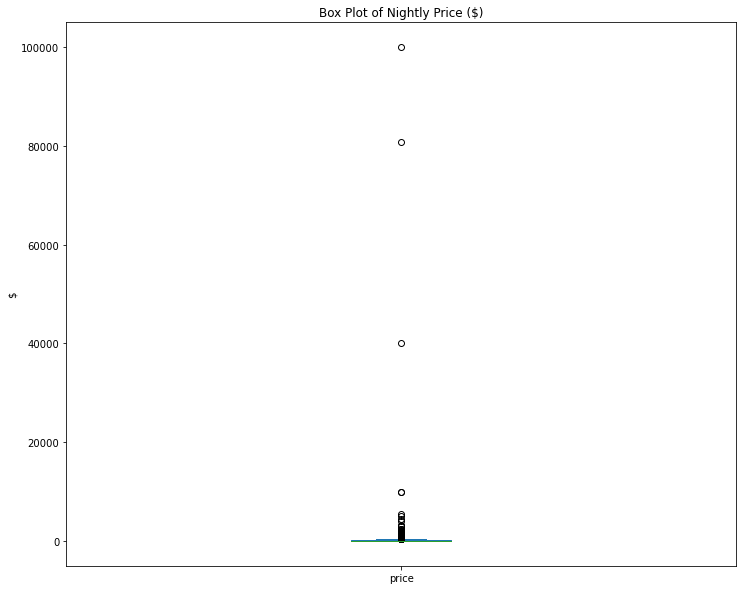

In [151]:
# Plotting price
plt.figure(figsize = (12,10))
plt.title('Box Plot of Nightly Price ($)')
df['price'].plot(kind = 'box')
plt.ylabel('$')

In [152]:
# SEE BELOW FOR FILLING OUTLIERS USING KMEANS CLUSTERING + MEAN

# FIELDS WITH ALL / MOST MISSING

In [153]:
# completely empty fields
df.drop(['neighbourhood_group_cleansed','calendar_updated'], axis =1 , inplace = True)
# replacing null with None, for any relevant text fields / information fields
df['neighborhood_overview'] = np.where(df['neighborhood_overview'].isnull(),'None',df['neighborhood_overview'])
# ONLY KEEPING NEIGHBORHOOD = CHICAGO, OR NULL + DESCRIPTION = CHICAGO
df = df[(df['neighbourhood'].str.contains('Chicago,', na = False, case = False))|((df['neighbourhood'].isnull())&(df['description'].str.contains('Chicago', na = False, case = False)))].reset_index(drop = True)
# Dropping irrelevant fields
df.drop(['neighbourhood','listing_url','scrape_id','picture_url','source','picture_url','host_url','host_name',
        'host_thumbnail_url','host_picture_url','calendar_last_scraped','host_neighbourhood', 'host_id',
        'neighbourhood_cleansed','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
        'has_availability','host_location','minimum_minimum_nights','maximum_minimum_nights', 'minimum_maximum_nights',
        'maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'name','host_about',
        'property_type'], axis = 1, inplace = True)

# Feature Engineering

In [154]:
# BASIC Feature Engineering (date dif + encoding)
df['days_since_last_review'] = (pd.to_datetime(df['last_scraped'])-pd.to_datetime(df['last_review'])).dt.days
df['days_since_first_review'] = (pd.to_datetime(df['last_scraped'])-pd.to_datetime(df['first_review'])).dt.days
# note, there will be some nan due to listings with 0 reviews... those will be seperately split out later
df['days_since_host'] = (pd.to_datetime(df['last_scraped'])-pd.to_datetime(df['host_since'])).dt.days
df.drop(['first_review','last_review','host_since'], axis = 1, inplace = True)

#one hot encoding
df['host_is_superhost'] = np.where(df['host_is_superhost'] == 'f',0,1)
df['host_has_profile_pic'] = np.where(df['host_has_profile_pic'] == 'f',0,1)
df['host_identity_verified'] = np.where(df['host_identity_verified'] == 'f',0,1)
df['instant_bookable'] = np.where(df['instant_bookable'] == 'f',0,1)

#dummy variable
df = pd.get_dummies(df,columns = ['host_verifications','room_type'], drop_first = True)

# Extracting Key Words : Description + Neighborhood

In [155]:
text_fields = ['description','neighborhood_overview']

# Functions used to clean text, and extract keywords
import re
import nltk
from Levenshtein import distance as levenshtein_distance
from rake_nltk import Rake
from collections import Counter

def preprocess_text(text):
    text = text.lower()
    # remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # remove special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

stop = set(nltk.corpus.stopwords.words('english'))

# Extract keywords from text: using brute count
def extract_keywords_count(text):
    # split each word from text
    words = text.split()
    #filter keywords for at least > 4 charecters and not a stop word
    words = list(filter(lambda x: len(x) >= 4 and x not in stop, words))
    # only top 10 occurances
    keywords = [element[0] for element in Counter(words).most_common(10)]
    return keywords

# Getting the key phrases using RAKE Algorithim
def extract_key_phrase(text):
    key_phrases = Rake()
    key_phrases.extract_keywords_from_text(preprocess_text(text))
    #using RAKE 
    ranked_phrases = key_phrases.get_ranked_phrases()
    ranked_phrases = list(dict.fromkeys(ranked_phrases))[:10]
    return ranked_phrases

# Unique between key words brute count + keyphrases RAKE
def merge_description(lst):
    if len(lst) <3:
        return lst
    filtered_list =[lst[0]]
    for item in lst[1:]:
        distance_score = 1-(levenshtein_distance(item.replace(' ',''), lst[0].replace(' ','')) / (max(len(item.replace(' ','')),len(lst[0].replace(' ','')))))
        if distance_score <= .5:
            filtered_list.append(item)
    return filtered_list

for x in range(len(text_fields)):
    df[text_fields[x]+'_1'] = df[text_fields[x]].map(preprocess_text).map(extract_keywords_count)
    df[text_fields[x]+'_2'] = df[text_fields[x]].map(preprocess_text).map(extract_key_phrase)
    df[text_fields[x]] = df.apply(lambda row: merge_description(list(set(row[text_fields[x]+'_1']).union(set(row[text_fields[x]+'_2'])))), axis = 1)
    df.drop([text_fields[x]+'_1',text_fields[x]+'_2'], axis = 1, inplace = True)

# USING KMEANS CLUSTERING TO CLUSTER TEXT FIELDS

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# TURNING AMENITIES INTO A REAL LIST
import ast
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))

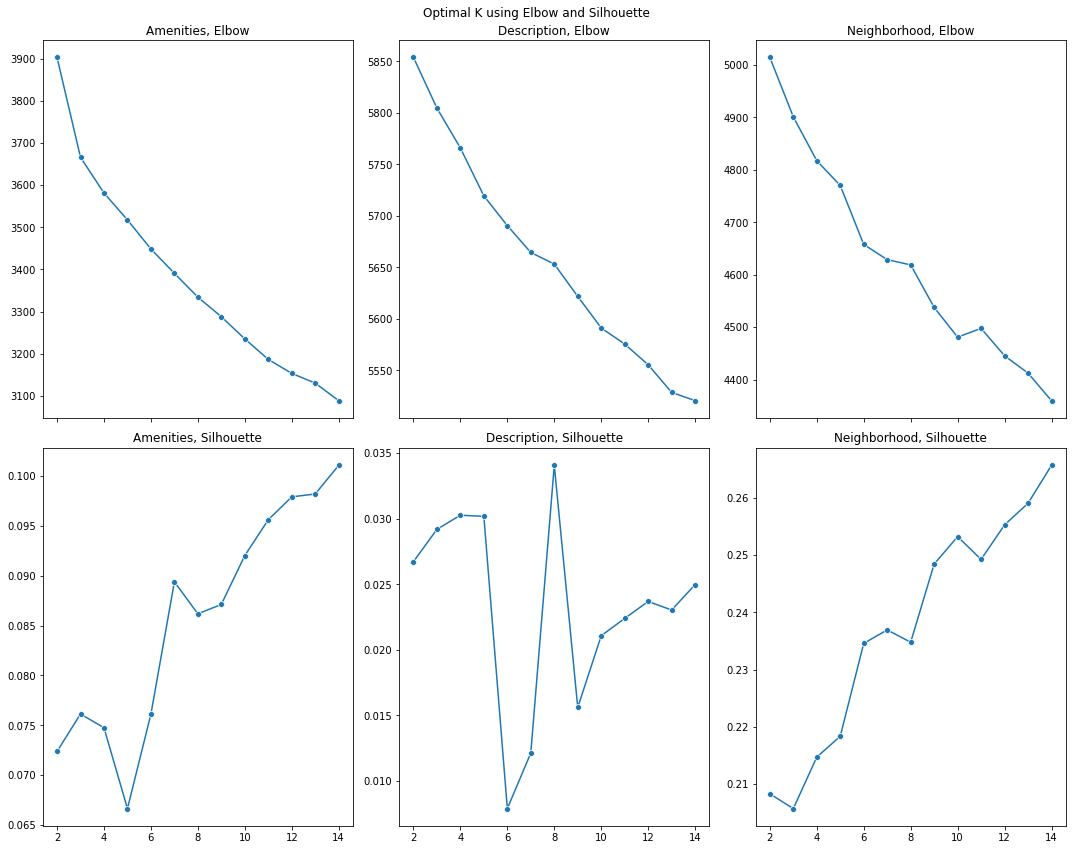

In [157]:
# OPTIMAL K CALCULATION
K = range(2,15)

# Elbow method and silhouette method for K in amenities
squared_distances_amen = []
silhouette_score_amen = []
for k in K:
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['amenities'].apply( lambda x:' '.join(x)))
    km = KMeans(n_clusters=k, random_state = 1)
    km = km.fit(X)
    squared_distances_amen.append(km.inertia_)
    y_pred = km.fit_predict(X)
    silhouette_score_amen.append(silhouette_score(X,y_pred))

# Elbow method and silhouette method for K in description
squared_distances_des = []
silhouette_score_des = []
for k in K:
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['description'].apply( lambda x:' '.join(x)))
    km = KMeans(n_clusters=k, random_state = 1)
    km = km.fit(X)
    squared_distances_des.append(km.inertia_)
    y_pred = km.fit_predict(X)
    silhouette_score_des.append(silhouette_score(X,y_pred))

# Elbow method and silhouette method for K in neighborhood
squared_distances_nei = []
silhouette_score_nei = []
for k in K:
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['neighborhood_overview'].apply( lambda x:' '.join(x)))
    km = KMeans(n_clusters=k, random_state = 1)
    km = km.fit(X)
    squared_distances_nei.append(km.inertia_)
    y_pred = km.fit_predict(X)
    silhouette_score_nei.append(silhouette_score(X,y_pred))

fig,axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15,12), sharex = True)

axs[0,0].set_title('Amenities, Elbow')
axs[0,1].set_title('Description, Elbow')
axs[0,2].set_title('Neighborhood, Elbow')
axs[1,0].set_title('Amenities, Silhouette')
axs[1,1].set_title('Description, Silhouette')
axs[1,2].set_title('Neighborhood, Silhouette')

sns.lineplot(x = K, y = squared_distances_amen, marker='o', ax = axs[0,0])
sns.lineplot(x = K, y = squared_distances_des, marker='o', ax = axs[0,1])
sns.lineplot(x = K, y = squared_distances_nei, marker='o', ax = axs[0,2])
sns.lineplot(x = K, y = silhouette_score_amen, marker='o', ax = axs[1,0])
sns.lineplot(x = K, y = silhouette_score_des, marker='o', ax = axs[1,1])
sns.lineplot(x = K, y = silhouette_score_nei, marker='o', ax = axs[1,2])



plt.suptitle('Optimal K using Elbow and Silhouette')
plt.tight_layout()

In [158]:
# EXPORT Squared distance and Silhouette 
#k_df = pd.DataFrame([squared_distances_amen,squared_distances_des,squared_distances_nei,
#             silhouette_score_amen,silhouette_score_des,silhouette_score_nei]).transpose()
#k_df.columns = ['sq_amen','sq_des','sq_nei',
#               'sil_amen','sil_des','sil_nei']
#k_df.to_pickle(("./KData.pkl"))
#k_df

In [159]:
# CLUSTERING WITH K MEANS
fields = ['description','neighborhood_overview', 'amenities']
ks = [7,4,9]
for i in range(len(fields)):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df[fields[i]].apply( lambda x:' '.join(x)))
    km= KMeans(n_clusters = ks[i], random_state = 1).fit(X)
    df[fields[i]] = km.labels_
#dummy variable for text cluster
df = pd.get_dummies(df,columns = fields, drop_first = True)

# CLEANING UP FINAL COLUMNS

In [160]:
#dummy variable for host response time
df = pd.get_dummies(df,columns = ['host_response_time',], drop_first = True)

# CONVERTING STRING TO FLOAT
df['host_response_rate'] = df['host_response_rate'].str[:-1].astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str[:-1].astype(float)

# TREAT MISSING LICENSE AS NO LICENSE...
df['license'] = np.where((df['license'].str.contains('32+', na = False))|(df['license'].str.contains('registered|city registration|registration paid', na = False, case = False)),1,
         np.where(df['license'].str.contains('pending|to follow|applied for', na = False, case = False),0,
                  np.where(df['license'].str.contains('.*[0-9].*', regex=True, na = False),1,0)))

In [161]:
# COORDINATE DISTANCE TO THE LOOP AND LINCOLN PARK
import geopy.distance

the_loop = (41.883733,-87.628858)
lincoln_park = (41.921438,-87.651304)

df['mi_to_loop'] = df.apply(lambda row: geopy.distance.distance((row.latitude, row.longitude), the_loop).mi,axis=1)
df['mi_to_lincoln'] = df.apply(lambda row: geopy.distance.distance((row.latitude, row.longitude), lincoln_park).mi,axis=1)

df.drop(['latitude','longitude'], axis = 1, inplace = True)

# CLEANING UP OUTLIER PRICES - Part 2

Text(0, 0.5, '$')

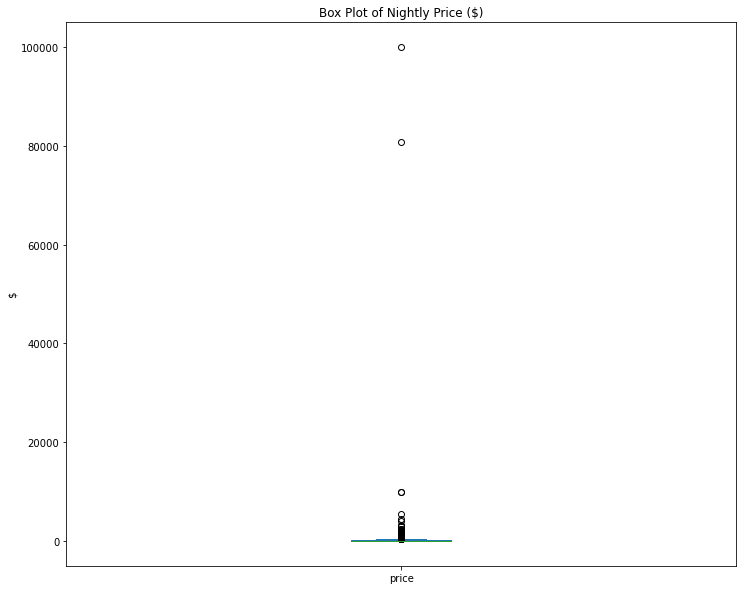

In [162]:
# Plotting price
plt.figure(figsize = (12,10))
plt.title('Box Plot of Nightly Price ($)')
df['price'].plot(kind = 'box')
plt.ylabel('$')

In [163]:
# Create a feature that describes the property
# combine: Description, neighborhood, amenities + + bathroom, bedroom, bed
text = df['description_1'].astype(str) +' '+ df['description_2'].astype(str) +' '+ \
df['description_3'].astype(str) + ' ' + df['description_4'].astype(str)+ ' ' + df['description_5'].astype(str) \
+ ' ' + df['description_6'].astype(str)+ ' ' + df['neighborhood_overview_1'].astype(str)+ ' ' + df['neighborhood_overview_2'].astype(str)\
+ ' ' + df['neighborhood_overview_3'].astype(str)+ ' ' + df['amenities_1'].astype(str)+ ' ' + df['amenities_2'].astype(str)\
+ ' ' + df['amenities_3'].astype(str)+ ' ' + df['amenities_4'].astype(str)+ ' ' + df['amenities_5'].astype(str)\
+ ' ' + df['amenities_6'].astype(str)+ ' ' + df['amenities_7'].astype(str)+ ' ' + df['amenities_8'].astype(str)\
+ ' ' + df['bathrooms_count'].astype(str)+ ' ' + df['bedrooms'].astype(str)+ ' ' + df['beds'].astype(str)


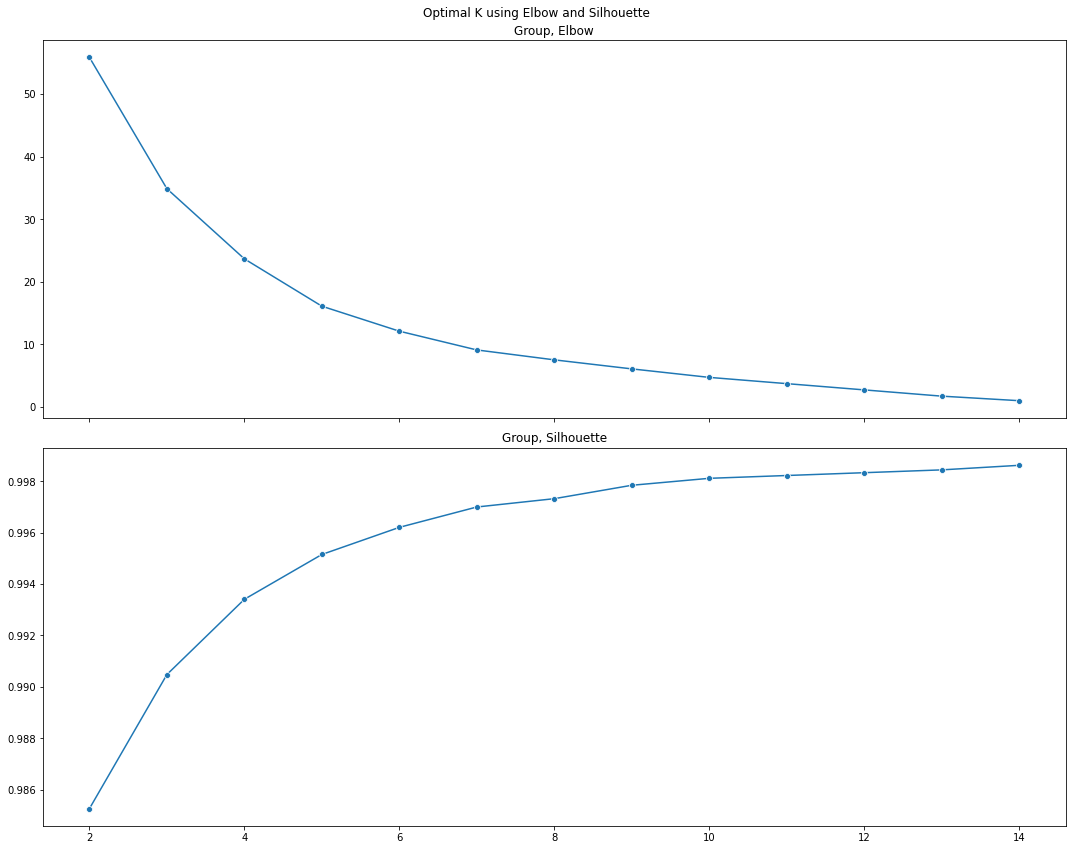

In [164]:
# OPTIMAL K CALCULATION
K = range(2,15)

# Elbow method and silhouette method for K in amenities
squared_distances_amen = []
silhouette_score_amen = []
for k in K:
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(text)
    km = KMeans(n_clusters=k, random_state = 1)
    km = km.fit(X)
    squared_distances_amen.append(km.inertia_)
    y_pred = km.fit_predict(X)
    silhouette_score_amen.append(silhouette_score(X,y_pred))

fig,axs = plt.subplots(nrows = 2, figsize = (15,12), sharex = True)

axs[0].set_title('Group, Elbow')
axs[1].set_title('Group, Silhouette')

sns.lineplot(x = K, y = squared_distances_amen, marker='o', ax = axs[0])
sns.lineplot(x = K, y = silhouette_score_amen, marker='o', ax = axs[1])

plt.suptitle('Optimal K using Elbow and Silhouette')
plt.tight_layout()

In [165]:
# CLUSTERING WITH K MEANS
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text)
km= KMeans(n_clusters = 7, random_state = 1).fit(X)
df['group'] = km.labels_

In [196]:
# IQR 2.5 : OUTLIER
iqr_outlier = df[(df['price']>=outlier('price',2.5)[0])].copy()
non_outlier = df[(df['price']<outlier('price',2.5)[0])].copy()

print('There are a total of '+str(len(iqr_outlier))+' outliers out of '+str(len(df))+' listings.')
print('The outlier cutoff is ' + str(outlier('price',2.5)[0]))

There are a total of 305 outliers out of 6452 listings.
The outlier cutoff is 469.0


In [197]:
# for reverse purposes
#df00 = df.copy()

In [199]:
# Which groups are in outlier data but not found in non outlier data
print(list(set(iqr_outlier['group'].unique())-set(non_outlier['group'].unique())))
dropcount = len(df[df['group'].isin(list(set(iqr_outlier['group'].unique())-set(non_outlier['group'].unique())))])
print('There are '+ str(dropcount)+' listings that were dropped as those listings were in groups that only contained outlier data.')
iqr_outlier = iqr_outlier[~iqr_outlier['group'].isin(list(set(iqr_outlier['group'].unique())-set(non_outlier['group'].unique())))].reset_index(drop = True)

[5, 6]
There are 7 listings that were dropped as those listings were in groups that only contained outlier data.


In [200]:
# What are the median and mean non outlier price for each group?
non_outlier.groupby('group')['price'].agg(['count','mean','median'])

# Price to replace outliers with
rep_price = pd.DataFrame(non_outlier.groupby('group')['price'].mean()).reset_index()

In [201]:
# REPLACE ALL OUTLIER WITH MEAN PRICE OF THE GROUP
groups = rep_price['group'].tolist()
for x in range(len(groups)):
    iqr_outlier['price'] = np.where(iqr_outlier['group']==groups[x],rep_price[rep_price['group']==groups[x]]['price'],iqr_outlier['price'])
               

In [206]:
# Merging nonoutlier with adjusted outlier
df_1 = pd.concat([non_outlier,iqr_outlier]).reset_index(drop = True).copy()
# validate that all listings merged back?
print('No Drop Outs?: ' + str(len(df_1)== (len(df)-dropcount)))

No Drop Outs?: True


# EXPORT PICKLE

In [210]:
# EXPORT DF TO PICKLE
df_1.to_pickle("./FullData.pkl")

In [211]:
# EXPORT THOSE WITHOUT A SINGLE REVIEW
# (SEPERATE PRICING MODELS)

no_review = df_1[df_1['number_of_reviews']==0].reset_index(drop = True).drop(['last_scraped','days_since_first_review',
                                                                         'days_since_last_review',
                                                                         'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
                                                                          'review_scores_rating', 'review_scores_accuracy',
                                                                          'review_scores_cleanliness', 'review_scores_checkin',
                                                                          'review_scores_communication', 'review_scores_location',
                                                                          'review_scores_value','reviews_per_month'], axis = 1).copy()
no_review.to_pickle("./No_Review.pkl")

review = df_1[df_1['number_of_reviews']>0].reset_index(drop = True).drop('last_scraped', axis = 1).copy()
review.to_pickle("./Reviewed.pkl")